### This tutorial takes you through the basics of analysing Mitty data with some help from cytoolz and pandas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import matplotlib.pyplot as plt
import cytoolz.curried as cyt
from bokeh.plotting import figure, show, output_file

In [5]:
import mitty.analysis.bamtoolz as bamtoolz
import mitty.analysis.bamfilters as mab
import mitty.analysis.plots as mapl

In [4]:
# import logging
# FORMAT = "[%(filename)s:%(lineno)s - %(funcName)20s() ] %(message)s"
# logging.basicConfig(format=FORMAT, level=logging.DEBUG)

In [6]:
# fname = '../../../mitty-demo-data/filter-demo-data/HG00119-bwa.bam'
# scar_fname = '../../../mitty-demo-data/generating-reads/HG00119-truncated-reads-corrupt-lq.txt'

# 180255 read pairs
fname = '../../../mitty-demo-data/alignment-accuracy/HG00119-bwa.bam'
scar_fname = '../../../mitty-demo-data/generating-reads/HG00119-reads-corrupt-lq.txt'

Ex1: Simple processing pipeline
---
Simple example showing how to create a processing pipeline and run it using cytoolz.pipe 

The components of the pipeline are

1. Parse read qname
2. Compute d_err
3. Categorize reads into some categories
4. Count 'em

In [7]:
max_d = 200
n1 = mab.parse_read_qnames(scar_fname)  # This gives us a curried function
n2 = mab.compute_derr(max_d=max_d)
f_dict = {
    'd = 0': lambda mate: mate['d_err'] == 0,
    '0 < d <= 50': lambda mate: 0 < mate['d_err'] <= 50,
    '50 < d': lambda mate: 50 < mate['d_err'] <= max_d,
    'WC': lambda mate: mate['d_err'] == max_d + 1,
    'UM': lambda mate: mate['d_err'] == max_d + 2
}
n3 = mab.categorize_reads(f_dict)
n4 = mab.count_reads

pipeline = [n1, n2, n3, n4]

In [8]:
%%time 
counts = cyt.pipe(
    bamtoolz.read_bam_st(bam_fname=fname), *pipeline)
print(counts, sum(counts.values(), 0))

Counter({'d = 0': 359585, 'nocat': 304, '0 < d <= 50': 276, 'WC': 190, '50 < d': 155}) 360510
CPU times: user 25 s, sys: 454 ms, total: 25.5 s
Wall time: 27.2 s


Ex2: Single reads and `scatter`
---

We now take the original pipeline and pass it to scatter to perform the same operation, but in parallel

In [10]:
%%time 
counts = sum(
    (c for c in bamtoolz.scatter(
        pipeline, bam_fname=fname, ncpus=4)
    ), mab.Counter())
print(counts, sum(counts.values(), 0))

Counter({'d = 0': 359585, 'nocat': 304, '0 < d <= 50': 276, 'WC': 190, '50 < d': 155}) 360510
CPU times: user 54.2 ms, sys: 24.5 ms, total: 78.7 ms
Wall time: 24.3 s


In [121]:
max_d = 200
n1 = mab.parse_read_qnames(scar_fname)  # This gives us a curried function
n2 = mab.compute_derr(max_d=max_d)
f_dict = {
    'd = 0': lambda mate: mate['d_err'] == 0,
    '0 < d <= 50': lambda mate: 0 < mate['d_err'] <= 50,
    '50 < d': lambda mate: 50 < mate['d_err'] <= max_d,
    'WC': lambda mate: mate['d_err'] == max_d + 1,
    'UM': lambda mate: mate['d_err'] == max_d + 2
}
n3 = mab.categorize_reads(f_dict)
n4 = mab.count_reads

pipeline = [n1, n2, n3, n4]

In [124]:
%%time 
counts = sum((c for c in bamtoolz.scatter(pipeline, bam_fname=fname, paired=True, ncpus=2)), mab.Counter())
print(counts, sum(counts.values(), 0))

Counter({'d = 0': 74249, 'WC': 981, 'UM': 304, '50 < d': 130, 'nocat': 116, '0 < d <= 50': 18}) 75798
CPU times: user 36.9 ms, sys: 18 ms, total: 54.8 ms
Wall time: 1.85 s


Ex3: Alignment histogram
----------------------





In [25]:
max_d = 200
n1 = mab.parse_read_qnames(scar_fname)  # This gives us a curried function
n2 = mab.compute_derr(max_d=max_d)
p1 = mab.default_histogram_parameters()  # The full 8D histogram
p1

{'max_d': 200,
 'mq_bin_edges': (0, 1, 11, 21, 31, 41, 51, 61),
 'name': 'PairedAlignmentHistogram',
 't_bin_edges': (-inf, 200, 301, 401, 601, inf),
 'v_bin_edges': (-inf, -20, 0, 1, 21, inf),
 'xd_bin_edges': (-inf,
  -100,
  -40,
  -20,
  -10,
  -5,
  0,
  1,
  6,
  11,
  21,
  41,
  101,
  inf),
 'xt_bin_edges': (-inf,
  -100,
  -40,
  -20,
  -10,
  -5,
  0,
  1,
  6,
  11,
  21,
  41,
  101,
  inf)}

In [26]:
p2 = mab.default_histogram_parameters()  # We'll do a detailed dive into MQ and d_err here
p2['mq_bin_edges'] = list(range(62))
p2['v_bin_edges'] = None
p2['t_bin_edges'] = None
p2['xt_bin_edges'] = None
p2['v_bin_edges'] = None

In [27]:
n3 = mab.histograminator(histogram_def=[p1, p2])

In [28]:
pipeline = [n1, n2, n3]

In [34]:
%%time 
h8 = cyt.pipe(
    bamtoolz.read_bam_paired_st(bam_fname=fname), 
    *pipeline)

CPU times: user 32.5 s, sys: 978 ms, total: 33.5 s
Wall time: 36.9 s


In [46]:
h8[0].attrs

OrderedDict([('max_v', 22),
             ('bin_centers',
              [array([  -inf,  -70. ,  -30. ,  -15. ,   -7.5,   -2.5,    0.5,    3.5,
                         8.5,   16. ,   31. ,   71. ,  151. ,  201.5,  202.5]),
               array([  -inf,  -70. ,  -30. ,  -15. ,   -7.5,   -2.5,    0.5,    3.5,
                         8.5,   16. ,   31. ,   71. ,  151. ,  201.5,  202.5]),
               array([  0.5,   6. ,  16. ,  26. ,  36. ,  46. ,  56. ]),
               array([  0.5,   6. ,  16. ,  26. ,  36. ,  46. ,  56. ]),
               array([ -inf, -10. ,   0.5,  11. ,  22. ,  23.5,  24.5]),
               array([ -inf, -10. ,   0.5,  11. ,  22. ,  23.5,  24.5]),
               array([ -inf, -70. , -30. , -15. ,  -7.5,  -2.5,   0.5,   3.5,   8.5,
                       16. ,  31. ,  71. ,   inf]),
               array([  -inf,  250.5,  351. ,  501. ,    inf])]),
             ('description',
              ['alignment error mate 1',
               'alignment error mate 2',
     

In [36]:
h8[1].sum()

<xarray.DataArray 'PairedAlignmentHistogram' ()>
array(180255)

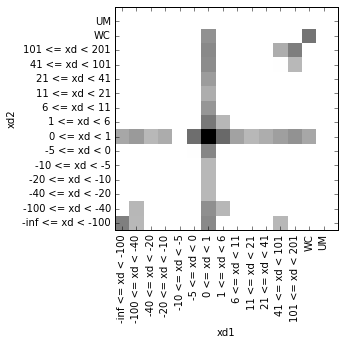

In [37]:
p2 = mab.collapse(h8[0], xd1=None, xd2=None)
mapl.plot_hist2D(p2)
plt.show()

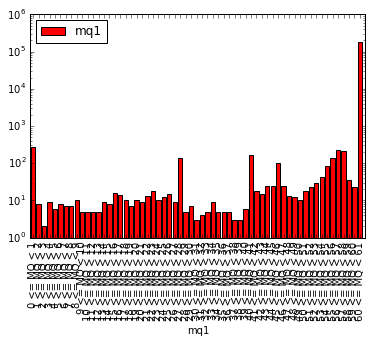

In [41]:
p2 = mab.collapse(h8[1], mq1=None)
mapl.plot_hist1D(p2)
plt.show()

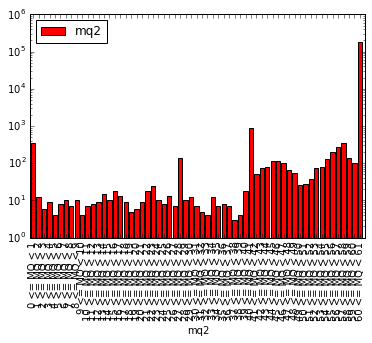

In [42]:
p2 = mab.collapse(h8[1], mq2=None)
mapl.plot_hist1D(p2)
plt.show()

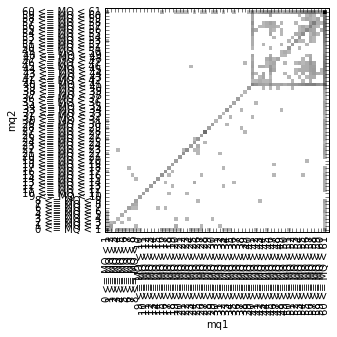

In [44]:
p2 = mab.collapse(h8[1], mq1=None, mq2=None)
mapl.plot_hist2D(p2)
plt.show()

In [151]:
max_d = 200
n1 = mab.parse_read_qnames(scar_fname)  # This gives us a curried function
n2 = mab.compute_derr(max_d=max_d)
p1 = mab.initialize_pah(name='FullHist')
n3 = mab.histogramize(pah=p1)

pipeline = [n1, n2, n3]

In [152]:
%%time
h8 = None
for h in bamtoolz.scatter(
    pipeline, 
    bam_fname=fname, paired=True, ncpus=2):
    print(h.sum())
    if h8 is None:
        h8 = h
    else:
        h8 += h   
print(h8.sum())

<xarray.DataArray 'FullHist' ()>
array(44)
<xarray.DataArray 'FullHist' ()>
array(180211)
<xarray.DataArray 'FullHist' ()>
array(180255)
CPU times: user 445 ms, sys: 9.79 s, total: 10.2 s
Wall time: 40 s


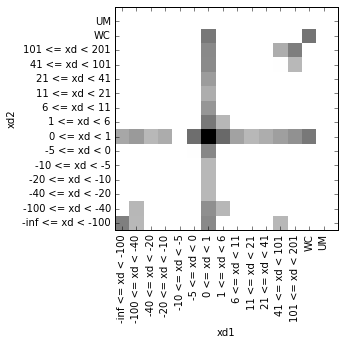

In [153]:
p2 = mab.collapse(h8, xd1=None, xd2=None)
mapl.plot_hist(p2)
plt.show()

In [75]:
h8.sum()

<xarray.DataArray 'FullHist' ()>
array(360510)

In [86]:
h10.sum()

<xarray.DataArray 'FullHist' ()>
array(721125)

Ex2
---
More involved example showing, in sequence:

1. Reading from a BAM
2. Pairing up the reads
3. Parse qnames (this is a simulated data set)
4. Compte d_err for the reads
5. Categorize reads based on d_err
6. Count reads in each category
7. Filter to keep non-reference reads only. Keep a pair only if both reads are non-ref
8. Re-Categorize reads based on d_err
9. Re-Count reads in each category

At the end the category counts are comparatively plotted.

In [5]:
r1 = mab.read_bam(bam_fname=fname)
r2 = mab.make_pairs
r3 = mab.parse_read_qnames(scar_fname)
r4 = mab.compute_derr(max_d=200)

f_dict = {
    'd = 0': lambda mate: mate['d_err'] == 0,
    '0 < d <= 50': lambda mate: 0 < mate['d_err'] <= 50,
    '50 < d': lambda mate: 50 < mate['d_err'] < 200,
    'WC': lambda mate: 200 < mate['d_err'],
    'UM': lambda mate: mate['read'].is_unmapped
}
r5 = mab.categorize_reads(f_dict)
all_counts = {}
r6 = mab.count_reads(all_counts) 
r7 = mab.filter_reads(mab.non_ref(), all)
r8 = mab.categorize_reads(f_dict)
nr_counts = {}
r9 = mab.count_reads(nr_counts)

for r in cyt.pipe(r1, r2, r3, r4, r5, r6, r7, r8, r9):
    pass

The new concept here is the use of a dictionary of filters to supply to the categorization function. The result is stored in the `all_counts` and `nr_counts` dictionaries which need to be preallocated and passed to the counting function which modifes them.

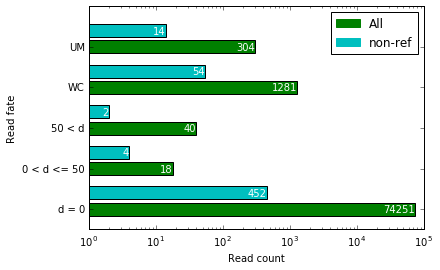

In [6]:
mapl.plot_read_counts(ax=plt.subplot(1, 1, 1), 
                      counts_l=[all_counts, nr_counts],
                      labels=['All', 'non-ref'],
                      keys=['d = 0', '0 < d <= 50', '50 < d', 'WC', 'UM'], 
                      colors=None)
plt.show()

Ex3
---
Alignment metrics plotting example

1. Read BAMs
2. Compute PairedAlignmentHistogram
3. Plot slices of the alignment

In [7]:
max_d = 200
r1 = mab.read_bam(bam_fname=fname)
r2 = mab.make_pairs
r3 = mab.parse_read_qnames(scar_fname)
r4 = mab.compute_derr(max_d=200)

p1 = mab.initialize_pah(name='FullHist')
mab.histogramize(pah=p1)(cyt.pipe(r1, r2, cyt.take(100000), r3, r4))
#mab.save_pah(p1, 'test_hist.pklz')

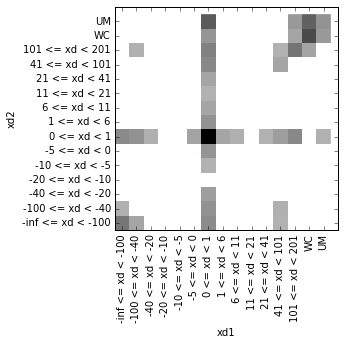

In [29]:
p2 = mab.collapse(p1, xd1=None, xd2=None)
mapl.plot_hist(p2)
plt.show()

The plot suggests that the error in aligning mate1 is largely unrelated to the error in aligning mate2 except for some cases where both mates are off by about the same amount  in the same direction (top, right and bottom left corners) or in opposite directions.

In [28]:
p2 = mab.collapse(p1, xd1=None, xd2=None)
mapl.plot_hist(p2)
plt.show()

36987

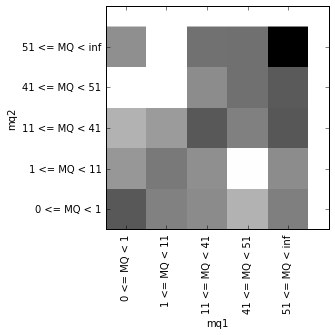

In [68]:
p2 = mab.collapse(p1, mq1=None, mq2=None)
mapl.plot_hist(p2)
plt.show()

In [47]:
p2.attrs

OrderedDict([('max_v', None),
             ('bin_centers',
              [array([  -inf,  -70. ,  -30. ,  -15. ,   -7.5,   -2.5,    0.5,    3.5,
                         8.5,   16. ,   31. ,   71. ,  151. ,  201.5,  202.5]),
               array([  -inf,  -70. ,  -30. ,  -15. ,   -7.5,   -2.5,    0.5,    3.5,
                         8.5,   16. ,   31. ,   71. ,  151. ,  201.5,  202.5]),
               array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
                        9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
                       18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
                       27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
                       36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
                       45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
                       54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5]),
               array([  0.

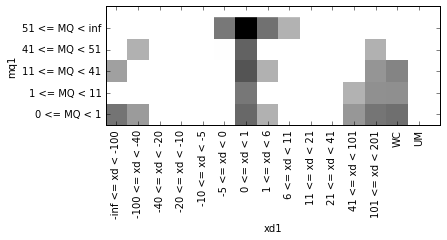

In [66]:
p2 = mab.collapse(p1, xd1=None, mq1=None)
mapl.plot_hist(p2)
plt.show()

In [100]:
p1.coords['v1']

<xarray.DataArray 'v1' (v1: 7)>
array(['-inf <= V < -20', '-20 <= V < 0', '0 <= V < 1', '1 <= V < 21',
       '21 <= V < 23', 'Ref', 'V+'], 
      dtype='<U15')
Coordinates:
  * v1       (v1) <U15 '-inf <= V < -20' '-20 <= V < 0' '0 <= V < 1' ...

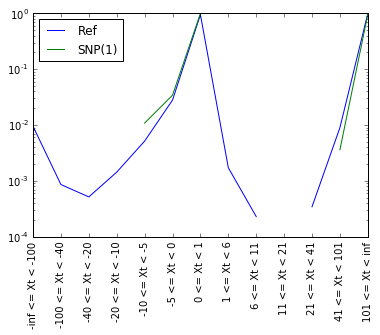

In [103]:
p2_r = mab.collapse(p1, xt=None, v1=(5, 6), v2=(5, 6))
p2_snp = mab.collapse(p1, xt=None, v1=(2, 3), v2=(5, 6))

plt.semilogy(p2_r/p2_r.max(), label='Ref')
plt.semilogy(p2_snp/p2_snp.max(), label='SNP(1)')

plt.legend(loc='best')
plt.xticks(range(p2_r.shape[0]), p2_r.coords['xt'].data, rotation='vertical')
plt.show()

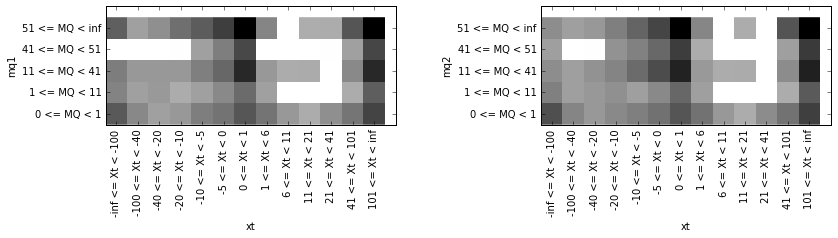

In [137]:
p2_1 = mab.collapse(p1, xt=None, mq1=None)
p2_2 = mab.collapse(p1, xt=None, mq2=None)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
plt.subplots_adjust(wspace=0.5)

mapl.plot_hist(p2_1.T, ax[0])
mapl.plot_hist(p2_2.T, ax[1])

plt.show()

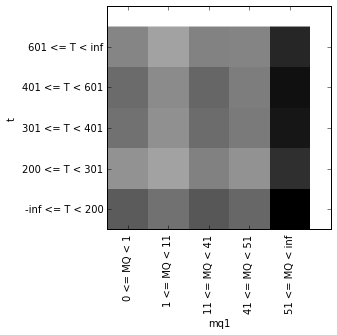

In [72]:
p2 = mab.collapse(p1, t=None, mq1=None)
mapl.plot_hist(p2)
plt.show()

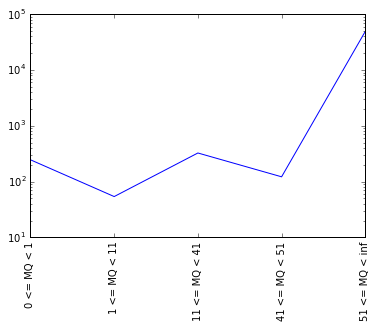

In [27]:
p2 = mab.collapse(p1, mq1=None)
plt.semilogy(p2)
plt.xticks(range(p2.coords['mq1'].values.size), p2.coords['mq1'].values, rotation='vertical')
plt.show()

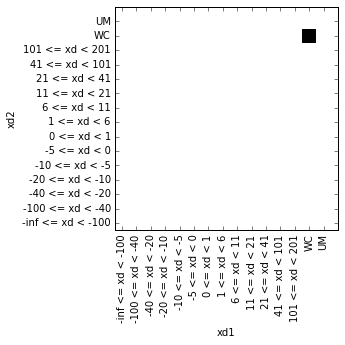

In [58]:
p2 = mab.collapse(p1, xd1=None, xd2=None, v1=(1, 2), v2=(5, 6))
mab.plot_hist(p2)
plt.show()

In [34]:
r1 = mab.read_bam(bam_fname=fname)

for r in cyt.pipe(r1, cyt.take(20)):
    tostring(r[0]['read'])

NameError: name 'tostring' is not defined

In [38]:
read = r[0]['read']

In [41]:
read.tostring(mab.pysam.AlignmentFile(fname))

'BT7|HG00119|20:1|1:3429775:40=::|0:3429189:40=::14G8A*\t161\t1\t1461351\t0\t8M1D26M6S\t10\t33768360\t0\tGTGCTAGGTTACAGATGTGAGCCCCCGTGCCCGGCCTTTT\t=<;>?>?>=1???9#=4>?>>;@#?@??>>>>?=>=??>?\tNM:i:2\tMD:Z:5G2^A26\tAS:i:26\tXS:i:25\tXA:Z:5,+137532258,15S25M,0;10,-94493697,17S23M,0;8,+37670470,23M17S,0;13,+26954599,17S23M,0;'

In [47]:
mab.pysam.AlignmentFile?


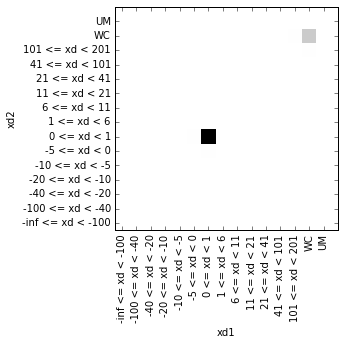

In [131]:
mab.plot_hist(p2)
plt.show()

In [122]:
p2.coords[p2.dims[0]].values

array(['-inf <= xd < -100', '-100 <= xd < -40', '-40 <= xd < -20',
       '-20 <= xd < -10', '-10 <= xd < -5', '-5 <= xd < 0', '0 <= xd < 1',
       '1 <= xd < 6', '6 <= xd < 11', '11 <= xd < 21', '21 <= xd < 41',
       '41 <= xd < 101', '101 <= xd < 201', 'WC', 'UM'], 
      dtype='<U17')

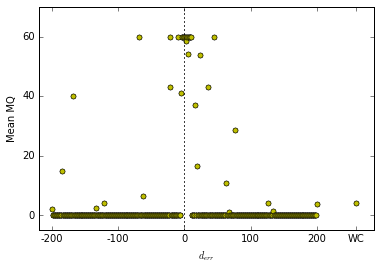

In [105]:
ax = plt.subplot(1,1,1)
mapl.plot_mean_MQ_vs_derr(ax=ax, dmv_mat=dmv_mat, fmt='yo', ms=5)
plt.show()

In [72]:
p1 = mab.initialize_pah()

In [74]:
len(p1.coords)

8

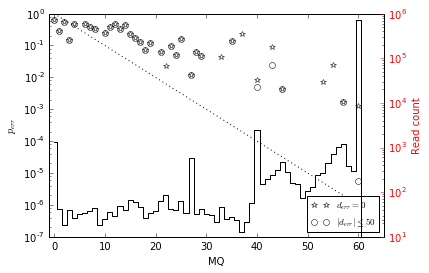

In [149]:
ax1 = plt.subplot(1,1,1)
mapl.plot_perr_vs_MQ(ax=ax1, dmv_mat=dmv_mat, yscale='log')
ax2 = ax1.twinx()
mapl.plot_read_count_vs_MQ(ax=ax2, dmv_mat=dmv_mat)
ax2.set_ylabel('Read count', color='r')
ax2.tick_params('y', colors='r')
ax1.legend(loc='lower right', fontsize=9)
plt.show()

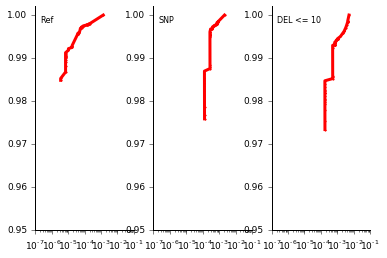

In [117]:
for n, v_bin_label in enumerate(
    ['Ref', 'SNP', 'DEL <= 10']):
    ax = plt.subplot(1, 3, n + 1)
    mapl.hengli_plot(ax=ax, dmv_mat=dmv_mat, v_bin_label=v_bin_label)
plt.show()

Ex4: Dataframes
--------------

In [150]:
r1 = mab.read_bam(bam_fname=fname, sidecar_fname=scar_fname)
r2 = mab.compute_derr(max_d=200)
r3 = mab.to_df(tags=['NM'])
df = cyt.pipe(r1, r2, cyt.take(20), r3)
df

,qname,mate,chrom,pos,cigar,MQ,d_err,correct_chrom,correct_pos,correct_cigar,NM
0,3E78,2,1,13655999,148M102S,0,201,20,2805905,250=,13
1,3E78,1,1,13656153,250M,0,201,20,2806059,250=,13
2,V91,2,1,25159291,155M95S,0,201,20,2805632,250=,13
3,V91,1,1,25159312,21S229M,0,201,20,2805632,250=,13
4,OMF,1,1,83806363,230M20S,1,201,20,1723777,250=,13
5,OMF,2,1,83806654,117S133M,1,201,20,1723603,250=,13
6,1MX7,2,1,90213017,142M108S,13,201,20,1724998,250=,13
7,1MX7,1,1,90213096,15S235M,13,201,20,1724934,250=,13
8,1I52,2,1,161392686,174M76S,18,201,20,2999958,250=,13
9,23Z8,1,1,164432660,222M28S,12,201,20,1723850,250=,13


In [151]:
r1 = mab.read_bam(bam_fname=fname, sidecar_fname=scar_fname)
r2 = mab.compute_derr(max_d=200)
r3 = mab.make_pairs
r4 = mab.to_df(tags=['NM'])
df = cyt.pipe(r1, r2, r3, cyt.take(20), r4)
df

qname mate1                                                         \
     NaN  mate chrom        pos         cigar  MQ d_err correct_chrom   
0   3E78     1     1   13656153          250M   0   201            20   
1    V91     1     1   25159312       21S229M   0   201            20   
2    OMF     1     1   83806363       230M20S   1   201            20   
3   1MX7     1     1   90213096       15S235M  13   201            20   
4   23Z8     1     1  164432660       222M28S  12   201            20   
5   31U4     1     1  171659566       24S226M   0   201            20   
6   2XAL     1     1  195896134          250M   0   201            20   
7   3NDP     1     1  196190500       24S226M   6   201            20   
8   19DY     1     1  212471810        244M6S   0   201            20   
9    ET1     1     1  213023701       12S238M   0   201            20   
10   NAH     1     1  244686794       225M25S   0   201            20   
11   I8D     1     2   14992152          250M   0   201            20   
12  298B     1     2   66343926  141M1I106M2S   1   201            20   
13  3CA5     1     2  173183389       233M17S  14   201            20   
14  394F     1     2  198554598       235M15S   0   201            20   
15  21FN     1     2  223016822          250M   0   201            20   
16   G2N     1     3   67865157        1S249M   0   201            20   
17  2254     1     3  103277760       26S224M   0   201            20   
18   AVB     1     3  152151311       228M22S  25   201            20   
19   K1Y     1     3  152953832       231M19S   2   201            20   

                                        ... mate2                   \
   correct_pos            correct_cigar ...  mate chrom        pos   
0      2806059                     250= ...     2     1   13655999   
1      2805632                     250= ...     2     1   25159291   
2      1723777                     250= ...     2     1   83806654   
3      1724934                     250= ...     2     1   90213017   
4      1723850                     250= ...     2     1  164432903   
5      1723859                     250= ...     2     1  171659447   
6      1723416                     250= ...     2     1  195896317   
7      1723454                     250= ...     2     1  196190464   
8      2805505                     250= ...     2     1  212471920   
9      1723322                     250= ...     2     1  213023234   
10     3479486                     250= ...     2     1  244686886   
11     3479428                     250= ...     2     2   14992155   
12     1725120                     250= ...     2     2   66344097   
13     1723043       59=1X9=1X13=1X166= ...     2     2  173183577   
14     1723089       13=1X9=1X13=1X212= ...     2     2  198554865   
15     1722928       174=1X9=1X13=1X51= ...     2     2  223016733   
16     1724987                     250= ...     2     3   67864864   
17     1723077       25=1X9=1X13=1X200= ...     2     3  103277593   
18     1615462  82=1X10=1X37=1X67=1X50= ...     2     3  152151409   
19     3774532                     250= ...     2     3  152954145   

                                                                             \
         cigar  MQ d_err correct_chrom correct_pos            correct_cigar   
0     148M102S   0   201            20     2805905                     250=   
1      155M95S   0   201            20     2805632                     250=   
2     117S133M   1   201            20     1723603                     250=   
3     142M108S  13   201            20     1724998                     250=   
4     130S120M  12   201            20     1723963                     250=   
5      166M84S   0   201            20     1723954                     250=   
6     106S144M   0   201            20     1723339                     250=   
7      169M81S   6   201            20     1723466                     250=   
8     110S140M   0   201            20     2805505               

In [51]:
import io
import pysam

In [52]:
fp = pysam.AlignmentFile(fname)

In [54]:
fout_str = io.StringIO()

In [56]:
pysam.AlignmentFile(fout_str, 'r')

NotImplementedError: access from StringIO objects not supported

In [57]:
read.tostring(mab.pysam.AlignmentFile(fname)).split('\t')

['BT7|HG00119|20:1|1:3429775:40=::|0:3429189:40=::14G8A*',
 '161',
 '1',
 '1461351',
 '0',
 '8M1D26M6S',
 '10',
 '33768360',
 '0',
 'GTGCTAGGTTACAGATGTGAGCCCCCGTGCCCGGCCTTTT',
 '=<;>?>?>=1???9#=4>?>>;@#?@??>>>>?=>=??>?',
 'NM:i:2',
 'MD:Z:5G2^A26',
 'AS:i:26',
 'XS:i:25',
 'XA:Z:5,+137532258,15S25M,0;10,-94493697,17S23M,0;8,+37670470,23M17S,0;13,+26954599,17S23M,0;']

In [86]:
def fromstring(s, ref_dict):
  """Inverse of pysam.AlignedSegment.tostring(): given a string, create an aligned segment

  :param s:
  :param ref_dict: ref_dict = {r: n for n, r in enumerate(fp.references)}
  :return:
  """
  def _split(_s):
    qname, flag, rname, pos, \
    mapping_quality, cigarstring, \
    rnext, pnext, template_length, seq, qual, *_tg = _s.split('\t')

    flag = int(flag)
    rname = ref_dict[rname]
    pos = int(pos)
    mapping_quality = int(mapping_quality)
    rnext = ref_dict[rnext]
    pnext = int(pnext)
    template_length = int(template_length)

    return qname, flag, rname, pos, \
      mapping_quality, cigarstring, \
      rnext, pnext, template_length, seq, qual, _tg

  # So close, pysam.tostring, so close
  def _tags(_t):
    _tl = _t.split(':')
    if _tl[1] == 'i':
      _tl[2] = int(_tl[2])
    elif _tl[1] == 'f':
      _tl[2] = float(_tl[2])

    return _tl[0], _tl[2], _tl[1]

  r = pysam.AlignedSegment()
  r.qname, r.flag, r.rname, r.pos, \
  r.mapping_quality, r.cigarstring, \
  r.rnext, r.pnext, r.template_length, r.seq, r.qual, tags = _split(s)
  r.set_tags([_tags(t) for t in tags])
  return r

In [87]:
read2 = fromstring(read.tostring(mab.pysam.AlignmentFile(fname)), ref_dict)

In [90]:
read2.tostring(mab.pysam.AlignmentFile(fname)).split()

['BT7|HG00119|20:1|1:3429775:40=::|0:3429189:40=::14G8A*',
 '161',
 '1',
 '1461352',
 '0',
 '8M1D26M6S',
 '10',
 '33768361',
 '0',
 'GTGCTAGGTTACAGATGTGAGCCCCCGTGCCCGGCCTTTT',
 '=<;>?>?>=1???9#=4>?>>;@#?@??>>>>?=>=??>?',
 'NM:i:2',
 'MD:Z:5G2^A26',
 'AS:i:26',
 'XS:i:25',
 'XA:Z:5,+137532258,15S25M,0;10,-94493697,17S23M,0;8,+37670470,23M17S,0;13,+26954599,17S23M,0;']

In [92]:
read.tostring(mab.pysam.AlignmentFile(fname)).split()

['BT7|HG00119|20:1|1:3429775:40=::|0:3429189:40=::14G8A*',
 '161',
 '1',
 '1461351',
 '0',
 '8M1D26M6S',
 '10',
 '33768360',
 '0',
 'GTGCTAGGTTACAGATGTGAGCCCCCGTGCCCGGCCTTTT',
 '=<;>?>?>=1???9#=4>?>>;@#?@??>>>>?=>=??>?',
 'NM:i:2',
 'MD:Z:5G2^A26',
 'AS:i:26',
 'XS:i:25',
 'XA:Z:5,+137532258,15S25M,0;10,-94493697,17S23M,0;8,+37670470,23M17S,0;13,+26954599,17S23M,0;']

In [11]:
fp = bamtoolz.pysam.AlignmentFile(fname)
fp.unmapped

304

In [9]:
import logging
logging.debug("hello world")

In [48]:
mab.save_histogram(p2, 'test_me.pklz')

In [49]:
p3 = mab.load_histogram('test_me.pklz')

In [52]:
p3.dims

('mq1', 'mq2')

In [53]:
p3.dims

('mq1', 'mq2')

In [54]:
p3

<xarray.DataArray 'PairedAlignmentHistogram' (mq1: 61, mq2: 61)>
array([[   251,      1,      1, ...,      0,      0,     13],
       [     2,      5,      1, ...,      0,      0,      0],
       [     0,      0,      2, ...,      0,      0,      0],
       ..., 
       [     0,      0,      0, ...,      3,      0,     13],
       [     0,      0,      0, ...,      0,      1,     10],
       [    42,      1,      1, ...,    124,     90, 175937]])
Coordinates:
  * mq1      (mq1) <U13 '0 <= MQ < 1' '1 <= MQ < 2' '2 <= MQ < 3' ...
  * mq2      (mq2) <U13 '0 <= MQ < 1' '1 <= MQ < 2' '2 <= MQ < 3' ...
Attributes:
    max_v:        None
    bin_centers:  [array([  -inf,  -70. ,  -30. ,  -15. ,   -7.5,   -2.5,    ...
    description:  ['alignment error mate 1', 'alignment error mate 2', 'mappi...
    bin_edges:    [array([ -inf, -100.,  -40.,  -20.,  -10.,   -5.,    0.,   ...
    max_d:        200